<a href="https://colab.research.google.com/github/chlolv/NLP_Project/blob/main/Main%20notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package and definitions


In [3]:
# BERT
# bi LSTM
# Hierarchical cross-entropy ?
# Bonne matrice de confusion

import requests as req
import pandas as pd
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
try :
  import transformers
except :
  !pip install transformers
  import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight

# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

git_url = "https://raw.githubusercontent.com/chlolv/NLP_Project/main/Data/"
H1_url = "H1.txt"
H2_url = "H2.txt"
H3_url = "H3.txt"
H4_url = "H4.txt"
H5_url = "H5.txt"
H6_url = "H6.txt"
H7_url = "H7.txt"



DEVICE =  Tesla K80


# Data import

In [4]:
H1 = req.get(git_url + H1_url)
H1 = H1.text
H2 = req.get(git_url + H2_url)
H2 = H2.text
H3 = req.get(git_url + H3_url)
H3 = H3.text
H4 = req.get(git_url + H4_url)
H4 = H4.text
H5 = req.get(git_url + H5_url)
H5 = H5.text
H6 = req.get(git_url + H6_url)
H6 = H6.text
H7 = req.get(git_url + H7_url)
H7 = H7.text

In [5]:
type(H1)
len(H1)

448810

In [7]:
len(H1)

448830

In [27]:
hps = [H1,H2,H3,H4,H5,H6,H7]
all_HP0 = [hp + "\n\n\n\n" for hp in hps] # list of all books
all_HP = "".join(hp for hp in all_HP0) # big string containing all books
print("The overall length of the seven books is: ", len(all_HP))
print("Here is the beginning of the first book: ", all_HP[0:100])

The overall length of the seven books is:  6276539
Here is the beginning of the first book:  Harry Potter and the Sorcerer's Stone 

CHAPTER ONE 

THE BOY WHO LIVED 

Mr. and Mrs. Dursley
Here are the titles of the books:  
1
HARRY POTTER
AND THE CHAMBER OF SECRETS
by
J. K. Rowling
(this is BOOK 2 in the Harry Potter series)
Original Scanned/OCR: Friday, April 07, 2000
v1.0
(edit where needed, change version number by 0.1)
C H A P T E O N E
THE WORST BIRTHDAY
Not for the first time, an argument had broken out over breakfast at
number four, Privet Drive. Mr. Vernon Dursley had been woken in
the early ho


# Data preprocessing

In [ ]:
# Paragraph split
H1_processed = H1.split('\r\n\r\n')
H1_processed = [sentence.strip() for sentence in H1_processed]

# Removing offnarration script (chapter, summary etc)
remove_list = []
for i in range(0, len(H1_processed)) :
  paragraph = H1_processed[i]
  if "CHAPTER" in paragraph :
    remove_list.append(i)
    remove_list.append(i+1)
for index in sorted(remove_list, reverse = True) :
  del H1_processed[index]
H1_processed = [paragraph for paragraph in H1_processed if paragraph not in ["Harry Potter and the Sorcerer's Stone", 'THE END']]

In [12]:
# Book split
books_processed = all_HP.split('\n\n\n\n')
books_processed = [book.strip() for book in all_HP]

In [42]:
books_processed = []

for book in range(3) : 
  print(book)
  # Paragraph split
  book_processed = all_HP0[book].split('\r\n\r\n')
  book_processed = [sentence.strip() for sentence in book_processed]
  
  # Removing offnarration script (chapter, summary etc)
  remove_list = []
  for i in range(0, len(book_processed)) :
    paragraph = book_processed[i]
    if "CHAPTER" in paragraph :
      remove_list.append(i)
      remove_list.append(i+1)
  for index in sorted(remove_list, reverse = True) :
    del book_processed[index]
  book_processed = [paragraph for paragraph in book_processed]
  print(book_processed)
  books_processed = books_processed.append(book_processed)

0
["Harry Potter and the Sorcerer's Stone", "Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.", 'Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere.', "The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn't think they could bear it if anyone found out about the Potters. Mrs. Potter was Mrs. Durs

AttributeError: ignored

In [36]:
book_processed[:300] # \xad ???

['',
 'he really wanted to do his homework but was forced to do it in secret,',
 'in the dead of night. And he also happened to be a wizard.',
 'It was nearly midnight, and he was lying on his stomach in bed, the blankets drawn right over his head like a tent, a flashlight in one hand and a large leather\xadbound book (A History of Magic by Bathilda Bagshot) propped open against the pillow. Harry moved the tip of his eagle\xadfeather quill down the page, frowning as he looked for something that would help him write his essay, "Witch Burning in the Fourteenth Century Was Completely Pointless discuss."',
 'The quill paused at the top of a likely\xadlooking paragraph. Harry Pushed his round glasses up the bridge of his nose, moved his flashlight closer to the book, and read:',
 'Non\xadmagic people (more commonly known as Muggles) were particularly afraid of magic in medieval times, but not very good at recognizing it.',
 'On the rare occasion that they did catch a real witch or wizard, b

# Further preprocessing


In [ ]:
H1_processed1 = H1_processed

# Merging short paragraph (dialogues mainly)
remove_list = []
for i in sorted(range(0, len(H1_processed1)), reverse = True) :
  paragraph = H1_processed1[i]
  if len(paragraph.split()) < 30 :
    remove_list.append(i)
    H1_processed1[i-1] += ' '
    H1_processed1[i-1] += H1_processed1[i]
for index in sorted(remove_list, reverse = True) :
  del H1_processed1[index]

# Basic analysis


In [ ]:
print(len(H1_processed1))
print(len([paragraph for paragraph in H1_processed1 if 'Harry' in paragraph]))
print(len([paragraph for paragraph in H1_processed1 if 'Ron' in paragraph]))
print(len([paragraph for paragraph in H1_processed1 if 'Hermione' in paragraph]))
print(len([paragraph for paragraph in H1_processed1 if 'Snape' in paragraph]))
print(len([paragraph for paragraph in H1_processed1 if 'Dumbledore' in paragraph]))
print(len([paragraph for paragraph in H1_processed1 if 'Dursley' in paragraph]))
print(len([paragraph for paragraph in H1_processed1 if 'Malfoy' in paragraph]))

1452
900
357
233
125
125
72
97


(array([769., 369., 162.,  69.,  40.,  17.,  11.,   9.,   2.,   4.]),
 array([ 30. ,  47.8,  65.6,  83.4, 101.2, 119. , 136.8, 154.6, 172.4,
        190.2, 208. ]),
 <a list of 10 Patch objects>)

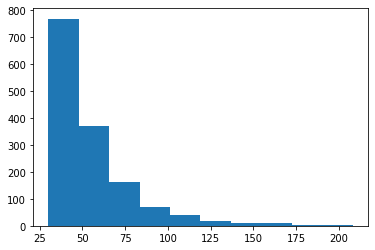

In [ ]:
len_list = []
for paragraph in H1_processed :
  len_list.append(len(paragraph.split()))

plt.hist(len_list)

# Further processing for training

In [ ]:
H1_processed2 = H1_processed1
for i in range(0, len(H1_processed2)) :
  H1_processed2[i] = re.sub("[!?]", '.', H1_processed2[i])
  H1_processed2[i] = H1_processed2[i].replace("...", '.')
  H1_processed2[i] = re.sub('[,\\-"()]', ' ', H1_processed2[i])
vocabulary = []
for i in range(0, len(H1_processed2)) :
  element = re.sub("[.]", ' ', H1_processed2[i])
  words = element.split()
  vocabulary.append(words)
vocabulary = [item for sublist in vocabulary for item in sublist]
voc_count = Counter(vocabulary)
voc_count = pd.DataFrame.from_dict(voc_count, orient = 'index').sort_values(by = [0], ascending = [False])
voc_count

,0
the,3310
to,1846
and,1808
a,1581
of,1249
...,...
owners,1
laps,1
Bedroom,1
scrawl:,1


In [ ]:
print(len(vocabulary))

77690


In [ ]:
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
for i, w in enumerate(vocabulary) :
   word_dict[w] = i + 4
   number_dict = {i: w for i, w in enumerate(word_dict)}
   vocab_size = len(word_dict)

# Training

In [ ]:
# On se rammène à une tâche de classification
labels = []
special_data = []
for paragraph in H1_processed2 :
  if 'Harry' in paragraph :
    labels.append(1)
  else :
    labels.append(0)
  patterns = ['Harry', 'Potter', 'Hermione', 'Granger', 'Ron', 'Ron Weasley', 'Dursley', 'Dudley', 'Vernon', 
              'Dumbledore', 'Albus', 'Severus', 'Snape', 'Draco', 'Malfoy', 'Hagrid', 'Voldemort']
  for pattern in patterns :
      paragraph = re.sub(pattern, 'charoffocus', paragraph)
  paragraph = re.sub('charoffocus charoffocus', 'charoffocus', paragraph)
  special_data.append(paragraph)
Counter(labels)

Counter({0: 552, 1: 900})

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(special_data, labels, 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=labels)
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
new_tokens = ['charoffocus']
num_added_toks = tokenizer.add_tokens(new_tokens)

In [ ]:
max_seq_len = 100

tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

In [ ]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
bert.resize_token_embeddings(len(tokenizer))

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
#model = model.to(device)

In [ ]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
#compute the class weights
class_wts = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[1.31606218 0.80634921]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
        
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
 
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step, batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

model = model.to(device)

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


# number of training epochs
epochs = 10

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.731
Validation Loss: 0.572

 Epoch 2 / 10

Evaluating...

Training Loss: 0.469
Validation Loss: 0.437

 Epoch 3 / 10

Evaluating...

Training Loss: 0.233
Validation Loss: 0.588

 Epoch 4 / 10

Evaluating...

Training Loss: 0.110
Validation Loss: 0.786

 Epoch 5 / 10

Evaluating...

Training Loss: 0.059
Validation Loss: 0.882

 Epoch 6 / 10

Evaluating...

Training Loss: 0.057
Validation Loss: 1.227

 Epoch 7 / 10

Evaluating...

Training Loss: 0.009
Validation Loss: 1.392

 Epoch 8 / 10

Evaluating...

Training Loss: 0.002
Validation Loss: 1.448

 Epoch 9 / 10

Evaluating...

Training Loss: 0.023
Validation Loss: 1.533

 Epoch 10 / 10

Evaluating...

Training Loss: 0.007
Validation Loss: 1.629


In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.57      0.66        83
           1       0.77      0.91      0.84       135

    accuracy                           0.78       218
   macro avg       0.79      0.74      0.75       218
weighted avg       0.78      0.78      0.77       218



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,47,36
1,12,123
